# Experiment Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from htc import (
    Config,
    LabelMapping,
    MetricAggregation,
    create_class_scores_figure,
    create_confusion_figure,
    create_running_metric_plot,
    create_training_stats_figure,
    normalize_grouped_cm,
    read_tfevent_losses,
    settings,
    show_loss_chart,
    utilization_table,
    visualize_dict,
)

In [2]:
# Parameter for papermill
run_dir = settings.training_dir / "image/2022-12-13_21-09-44_config_thoracic"

In [3]:
assert run_dir != "", "No run_dir specified"
if type(run_dir) == str:
    run_dir = Path(run_dir)
print(f"Model: {run_dir.parent.name}")
print(f"Experiment: {run_dir.name}")

Model: image
Experiment: 2022-12-13_21-09-44_config_thoracic


In [4]:
# Load training files
df_val = pd.read_pickle(run_dir / "validation_table.pkl.xz").query("dataset_index == 0")
df_train = read_tfevent_losses(run_dir)
config = Config(run_dir / "config.json")
mapping = LabelMapping.from_config(config)

# Aggregated metrics (respecting the hierarchy of the data) with a metric score per subject (due to mode="image_level")
agg = MetricAggregation(df_val, config, metrics=["dice_metric"])
df_grouped = agg.grouped_metrics(mode="class_level")

In [5]:
df_train.head()

,fold_name,epoch_index,step,lr-Adam,train/ce_loss_step,train/dice_loss_step,train/focal_loss_step,dice_metric,train/ce_loss_epoch,train/dice_loss_epoch,train/focal_loss_epoch
0,fold_P093,0,0,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fold_P093,0,49,NaN,0.001208,0.002644,0.000154,NaN,NaN,NaN,NaN
2,fold_P093,0,99,NaN,0.000268,0.000133,0.000068,0.980841,0.053798,0.07208,0.018887
3,fold_P093,0,100,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fold_P093,1,149,NaN,0.000105,0.000400,0.000019,NaN,NaN,NaN,NaN


In [6]:
df_val.head()

,epoch_index,dataset_index,image_name,subject_name,timestamp,dice_metric,used_labels,dice_metric_image,confusion_matrix,fold_name,best_epoch_index
0,0,0,P094#2021_04_30_17_10_23,P094,2021_04_30_17_10_23,[0.9418125],[1],0.941813,"[[0, 0], [3315, 26828]]",fold_P093,2
1,0,0,P094#2021_04_30_17_10_40,P094,2021_04_30_17_10_40,[0.9491525],[1],0.949153,"[[0, 0], [2859, 26684]]",fold_P093,2
2,0,0,P094#2021_04_30_17_10_57,P094,2021_04_30_17_10_57,[0.94838303],[1],0.948383,"[[0, 0], [2806, 25778]]",fold_P093,2
3,0,0,P094#2021_04_30_17_11_25,P094,2021_04_30_17_11_25,[0.93643266],[1],0.936433,"[[0, 0], [2010, 14805]]",fold_P093,2
4,0,0,P094#2021_04_30_17_11_42,P094,2021_04_30_17_11_42,[0.956015],[1],0.956015,"[[0, 0], [1419, 15421]]",fold_P093,2


In [7]:
df_grouped.head()

,label_index,dice_metric,label_name
0,1,0.999019,lung
1,0,1.000000,heart


## Config

In [8]:
visualize_dict(config.data)

## Metrics
Visualization of the metrics stored in the TensorBoard events file (everything which is logged via `selg.log()`).
> Note: In this case, every metric (except `dice_metric`) is computed on the training set.

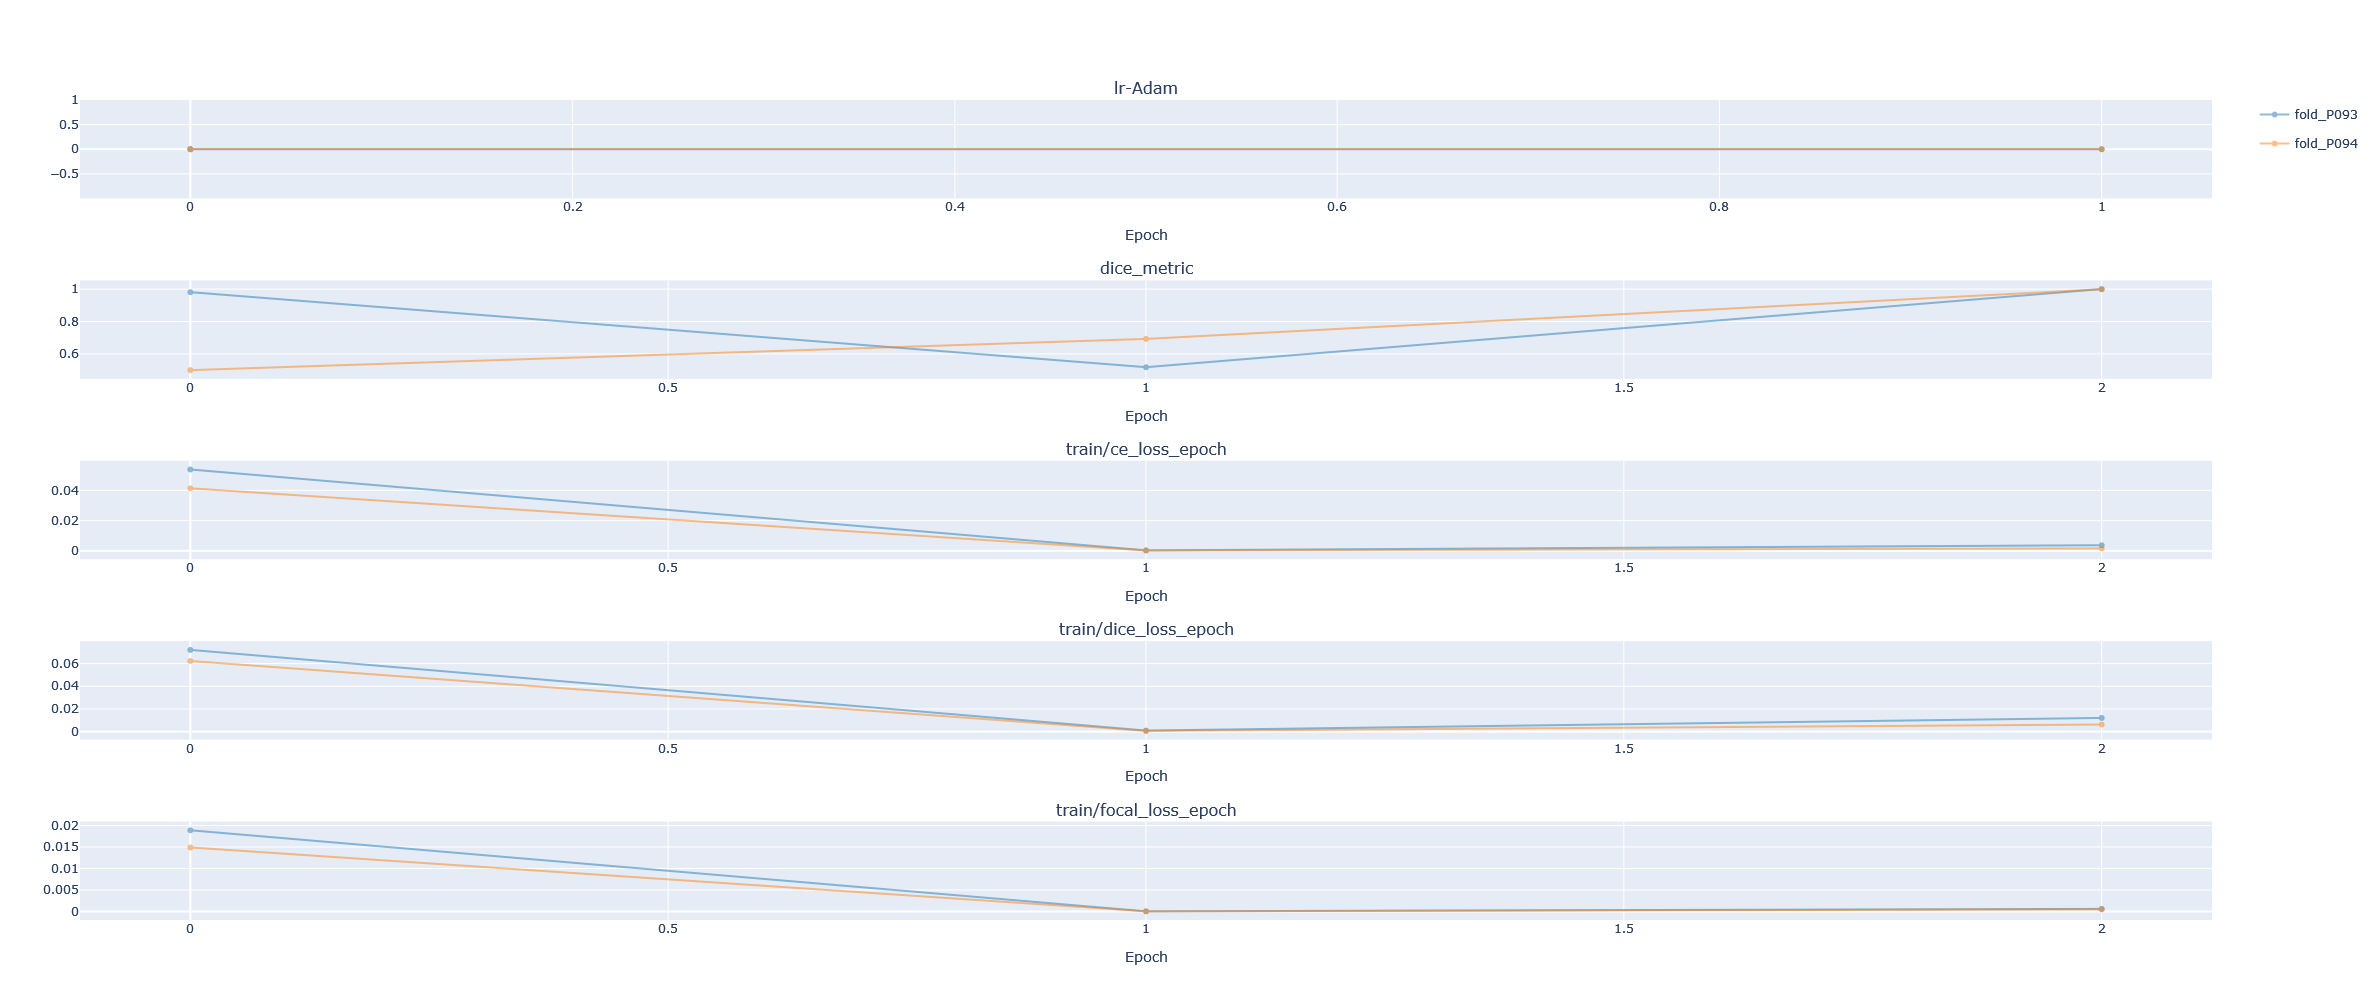

In [9]:
show_loss_chart(df_train, df_val)

For each fold, the current maximum for every epoch of the main metric (the checkpoint metric, `validation/checkpoint_metric` in the config).

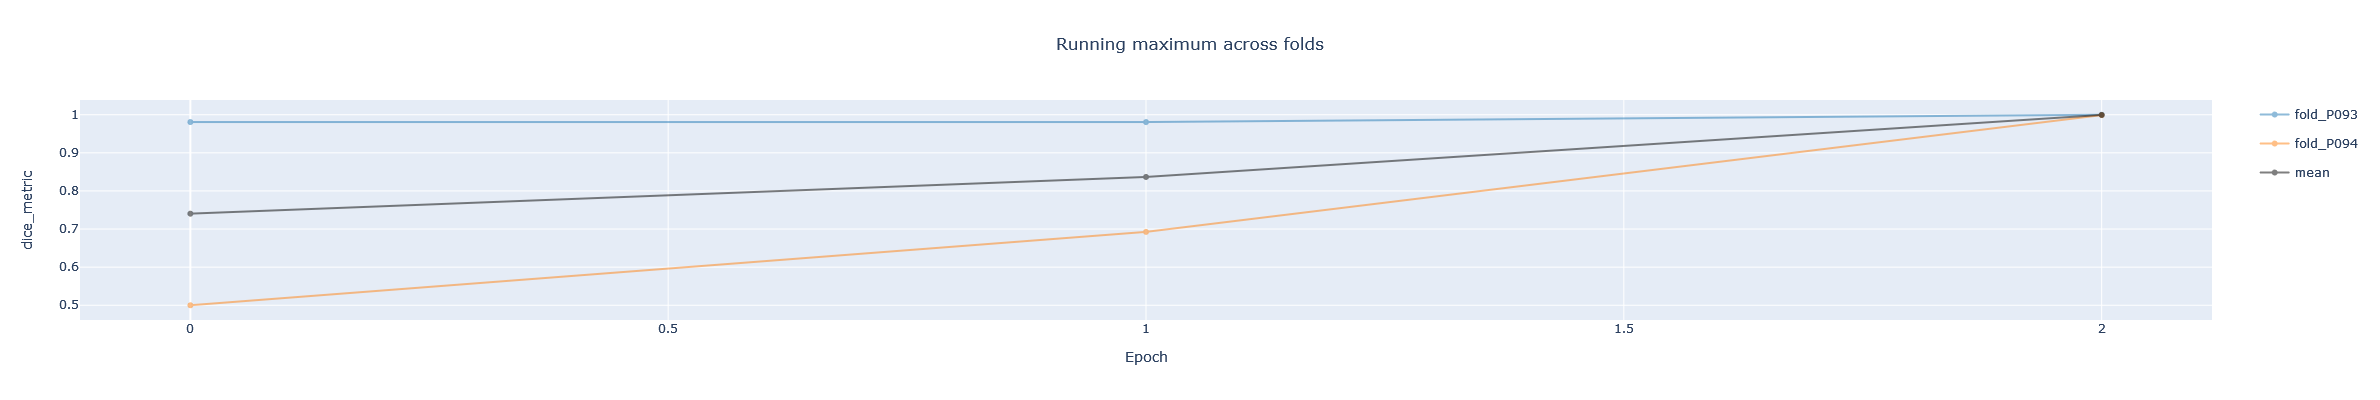

In [10]:
create_running_metric_plot(df_train)

## Training Statistics
The following heatmaps visualize which images the network saw during training. On the $y$-axis is the sorted (by image name) list of images and on the $x$-axis we have the training epochs. For each fold and epoch, we can see how often the network saw a particular image. Usually, we want a random order of images, so if you have the feeling you are looking at a noise image, everything is fine :-)

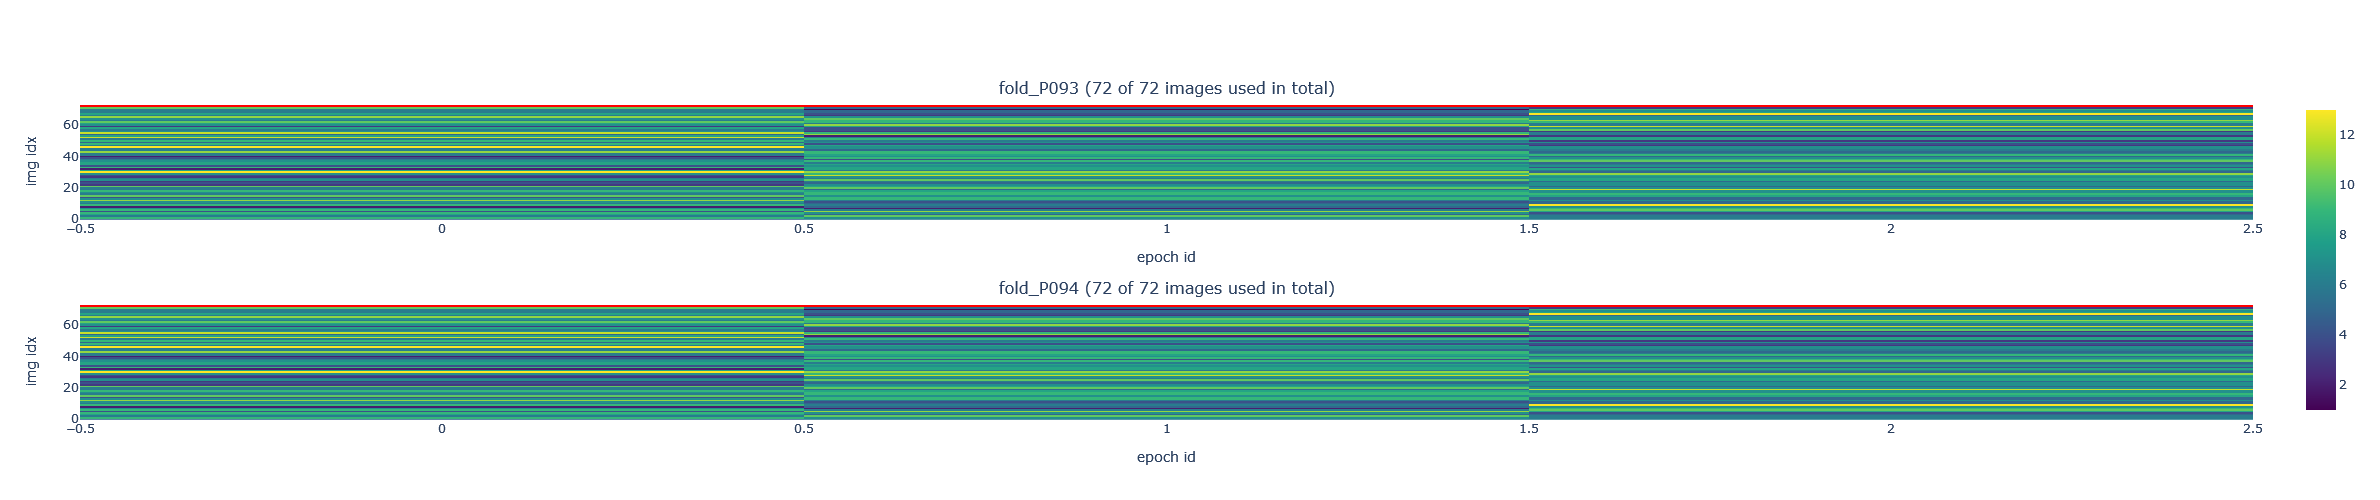

In [11]:
if len(sorted(run_dir.rglob("trainings_stats.npz"))) > 0:
    fig = create_training_stats_figure(run_dir)
    fig.show()

## Hardware Utilization
GPU and CPU utilization for each fold.
> Note: You will only get reasonable numbers if the training was long enough. For super short training times, you might get warnings or nan values

In [12]:
utilization_table(run_dir)

[WARNING][htc] No GPU with a utilization of at least 0.1 found                                   helper_functions.py:315
(log_path=/mnt/ssd_8tb/htc/results_test/training/image/2022-12-13_21-09-44_config_thoracic/fold_                        
P093/system_log_2022-12-13_21-09-49.json, all_gpus_load=[0.04])                                                         

[WARNING][py.warnings]                                                                                   warnings.py:109
/home/j562r/miniconda3/envs/htc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432:                            
RuntimeWarning:                                                                                                         
                                                                                                                        
Mean of empty slice.                                                                                                    
                                                                                                                        
                                                                                                                        

[WARNING][htc] No GPU with a utilization of at least 0.1 found                                   helper_functions.py:315
(log_path=/mnt/ssd_8tb/htc/results_test/training/image/2022-12-13_21-09-44_config_thoracic/fold_                        
P094/system_log_2022-12-13_21-11-35.json, all_gpus_load=[0.])                                                           

,fold,node,hours,gpu_util_mean,gpu_util_std,cpu_util_mean,cpu_util_std
0,fold_P093,e130-pc27,0.0,NaN,NaN,0.288500,0.0
1,fold_P094,e130-pc27,0.0,NaN,NaN,0.188375,0.0


## Class Scores (best run)

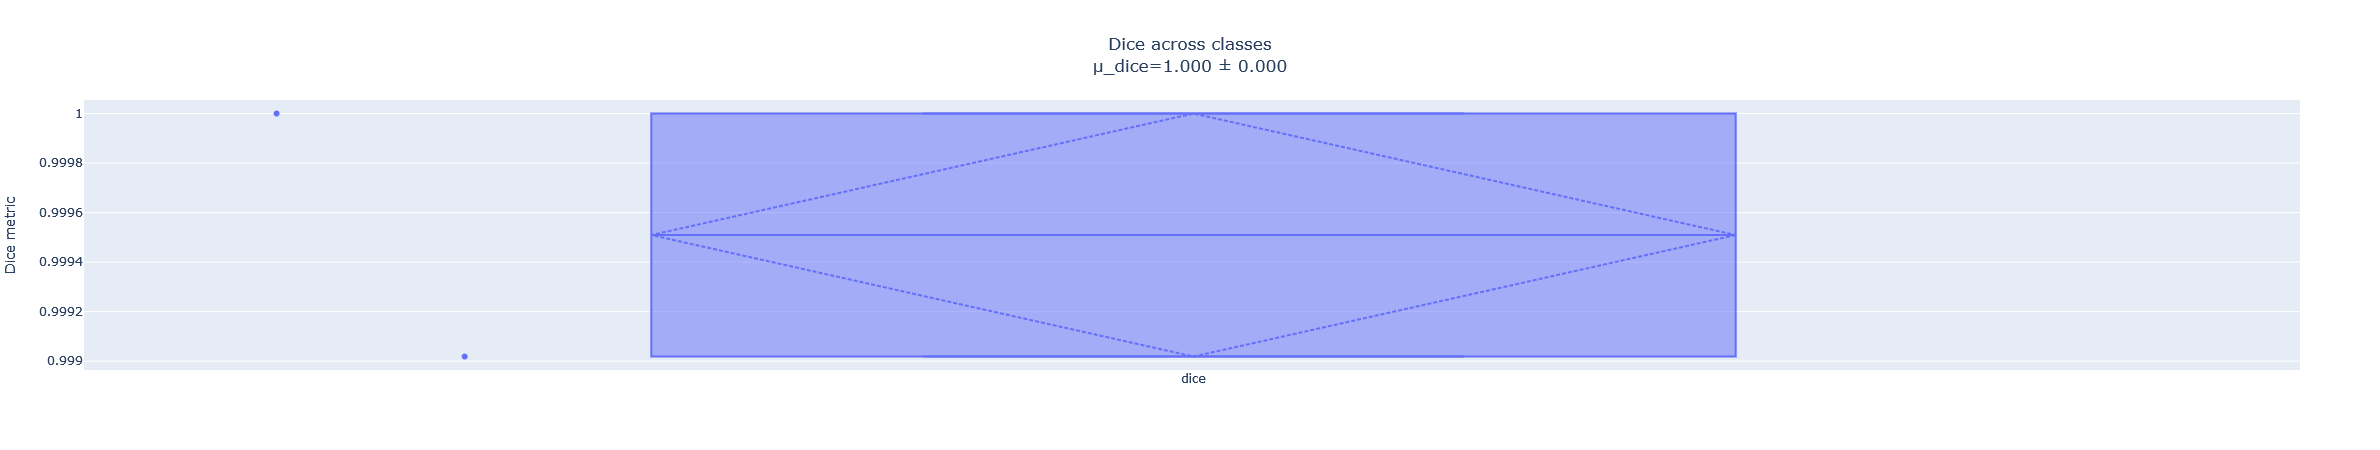

In [13]:
df_label = agg.grouped_metrics()

fig = go.Figure()
fig.add_trace(
    go.Box(y=df_label["dice_metric"], name="dice", boxmean="sd", boxpoints="all", text=df_label["label_name"])
)
fig.update_layout(
    title_x=0.5,
    title_text=(
        f"Dice across classes<br>μ_dice={df_label['dice_metric'].mean():.03f} ± {np.std(df_label['dice_metric']):.03f}"
    ),
)
fig.update_yaxes(title_text="Dice metric")
fig.update_layout(width=500, autosize=False)

Comparison of class dice scores. Each boxplot shows the distribution of dice values across subjects. The image and pixel counts are the sum over all images in the validation sets.

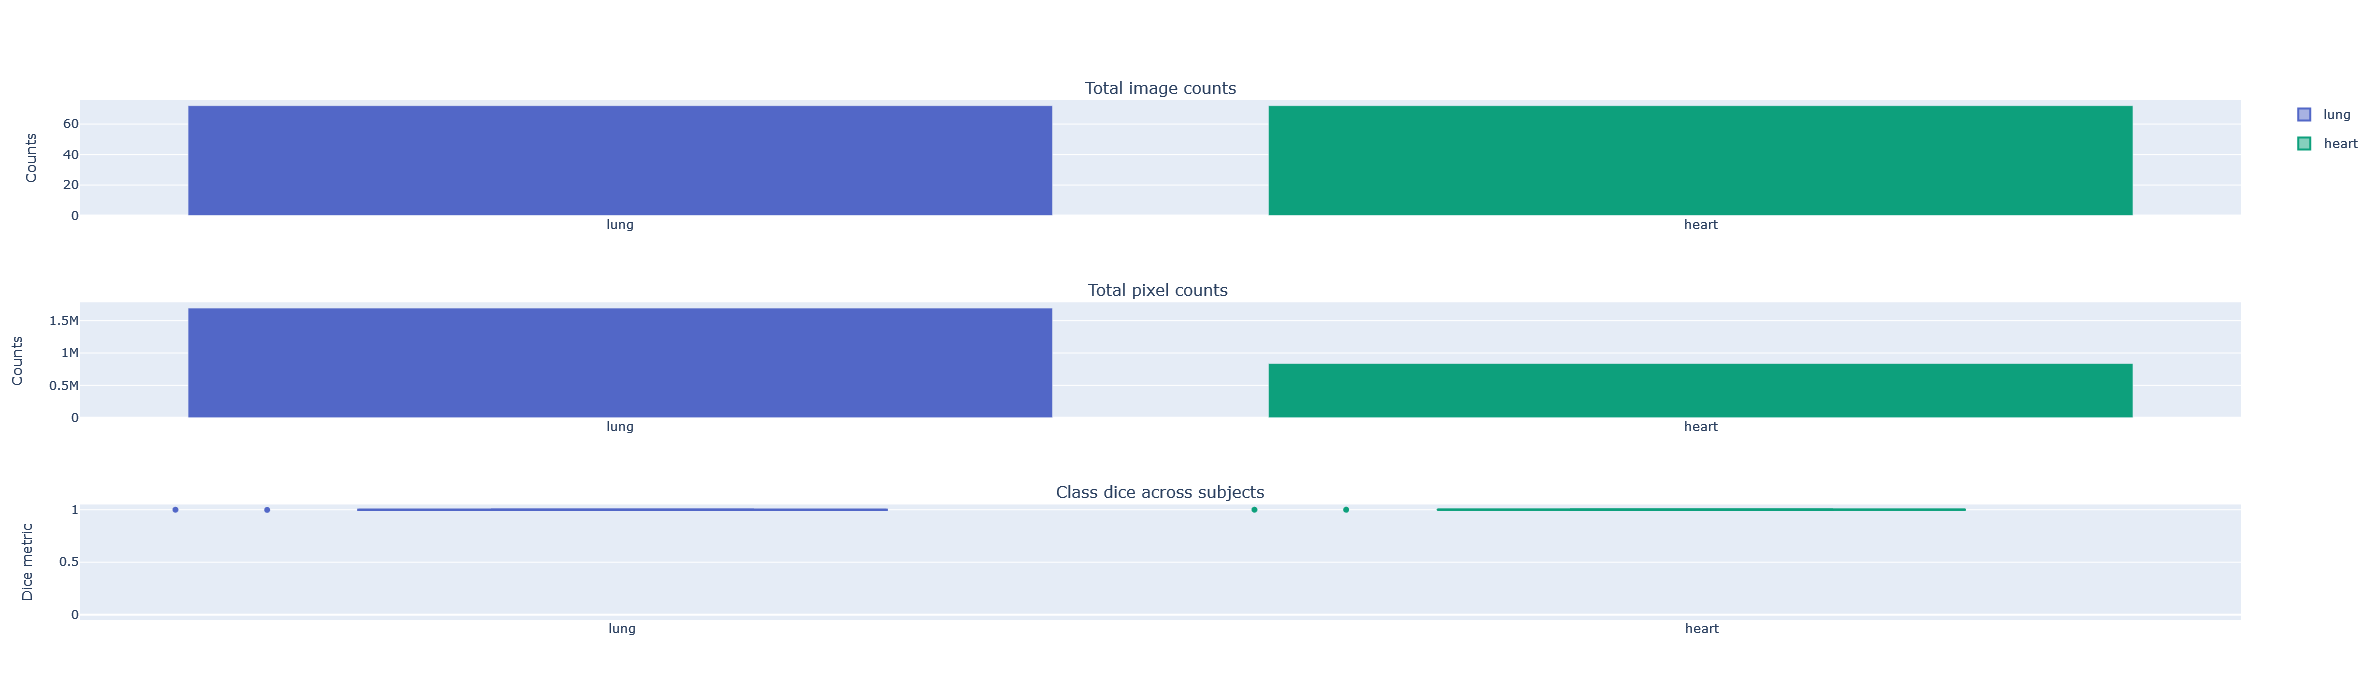

In [14]:
if "confusion_matrix" in df_val:
    create_class_scores_figure(agg)

## Confusion Matrix (best run)
Normalized confusion matrix. For each row, you can see how many of the annotated images were classified to the respective class.

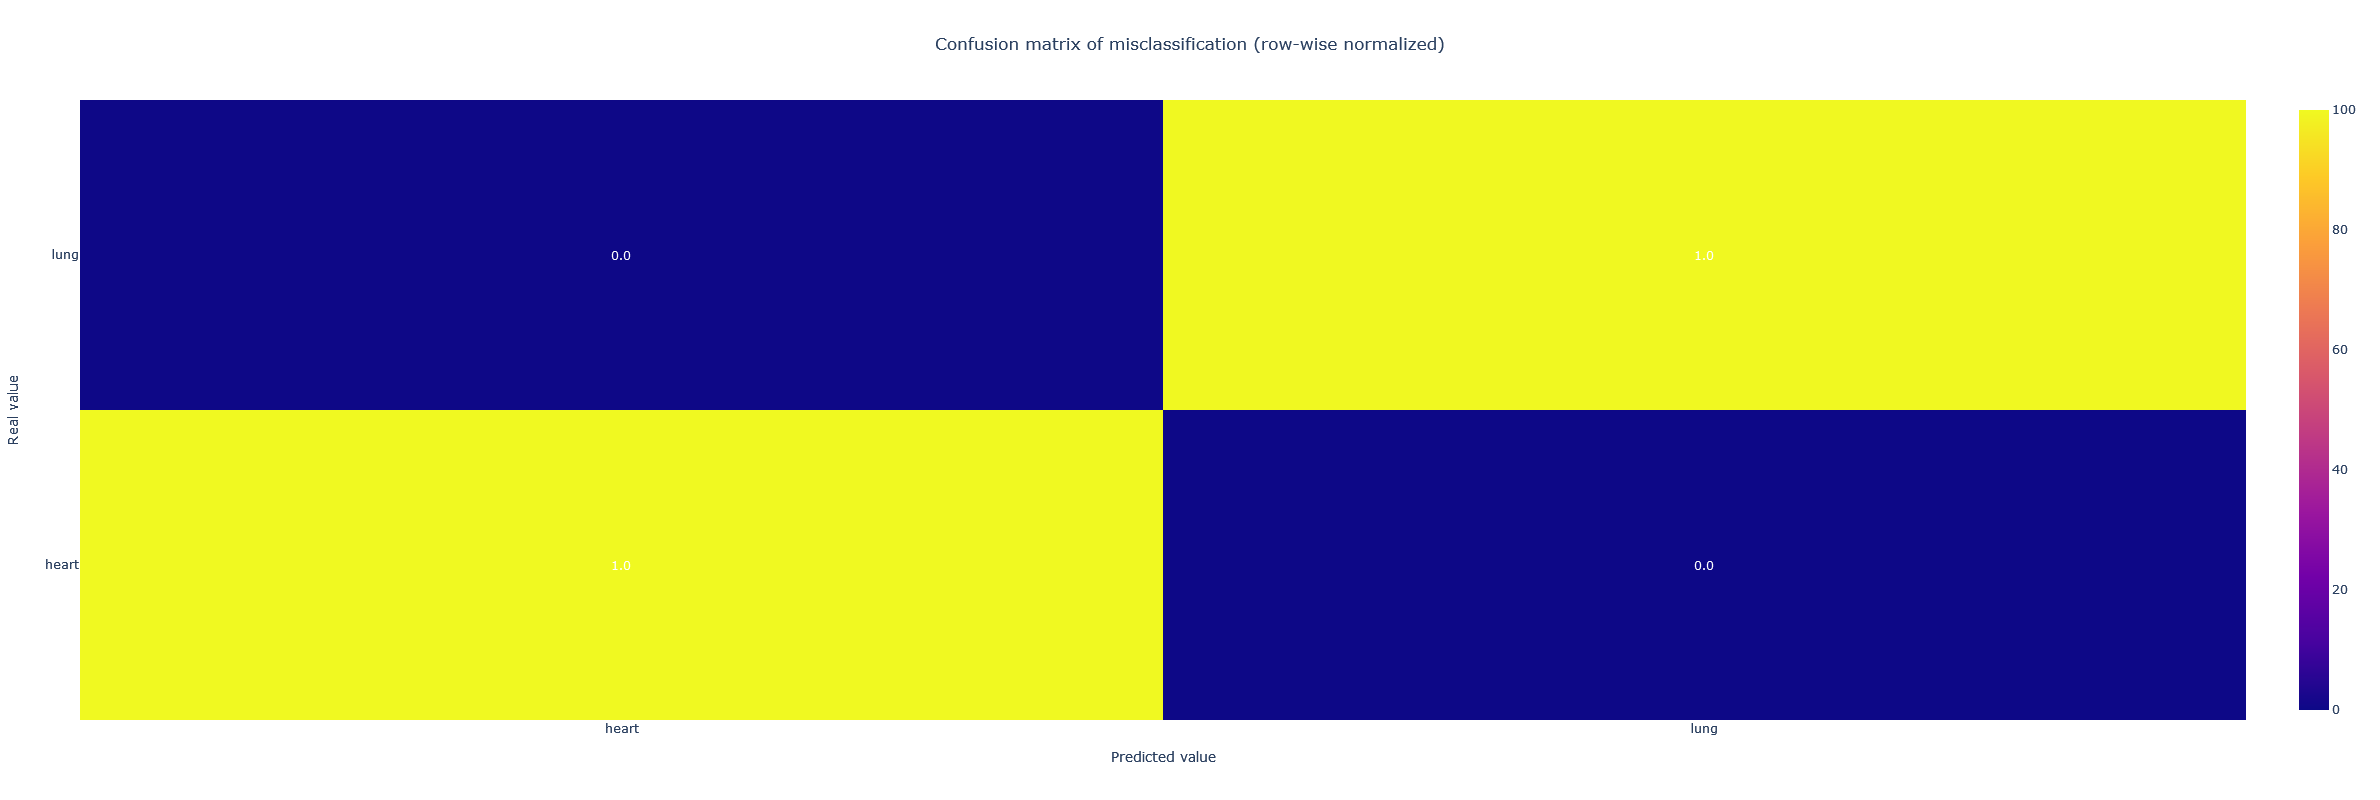

In [15]:
if "confusion_matrix" in df_val:
    cm_rel, cm_std = normalize_grouped_cm(np.stack(agg.grouped_cm()["confusion_matrix"].values))
    create_confusion_figure(cm_rel, labels=mapping.label_names()).show()